In [5]:
# Analysis of Tracked bifacial system from RMIS meteorological data and SolarWorld albedo.
# pull dataframe in via SQL, filter and plot in pyqtgraph
#
# Canadian Solar analysis - based on Bifacial_tracker_QCells_March2022.
# Re-use pickle files previously downloaded - see QCells notebook for download scripts

import numpy as np
import pandas as pd
import os
#from sqlalchemy import create_engine

import matplotlib.pyplot as plt
from matplotlib import style
#style.use('fivethirtyeight')
#style.use('seaborn-white')
print(style.available)

import pvlib
import datetime


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [6]:
#get_ipython().run_line_magic('matplotlib', 'notebook') #interactive matplotlib
get_ipython().run_line_magic('matplotlib', 'inline') # inline plotting for .py file use
plt.rcParams['timezone'] = 'Etc/GMT+7'

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [7]:
# select save directory
SAVEDIR = r'C:\Users\cdeline\Documents\Python Scripts\RTC analysis'

# directory needs to be where pvdrdb_queries resides
os.chdir(SAVEDIR)

In [8]:
# Import data
import pvdrdb_tools
from aws_access_cred_manager import aws_keys_and_tokens

# Get AWS credentials for S3 access.
# Param1=sso_role_name, param2= Boolean, to show credentials
creds = aws_keys_and_tokens.load_config('pvdrdb-developer', display=False)

# Make an instance of the Query class
pvq = pvdrdb_tools.PVDRDBQuery(creds)
# connect to the database
if pvq.connectToDB():
    #Get a list of all systems
    systemDF = pvq.getAllSystems(False)

C:\Users\cdeline\AppData\Roaming\Python\Python39\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Found AWS configuration file.
Found AWS credentials file.
Creds are out of synch. Write current creds to user's credential file.
Found AWS credentials file.
Attempting to connect to PVDRDB database:
Successfully connected to PVDRDB database:
   system_id                                      name
0          1  OTF-ASE-Parallel Configuration 295 - 409
1          2                            Nelson Array 1
2          3                            Nelson Array 2
3          4                                    Sanyo1
4          5          OTF-SCI1-PosNeg Config 695 - 509


In [9]:
TZ = 'Etc/GMT+7'  # local timezone to return data in.

def callData(systemID, startDate, endDate):
    dataTagName='cdeline_'+str(systemID)+'_' #
    
    columnName = 'sensor_name'
    pvq.querySystemData(systemID, dataTagName, columnName, 
                        startDate=startDate, endDate=endDate)
    return dataTagName


def downloadDF(dataTagName):
    tsDf = pvq.compile_df(dataTagName=dataTagName)
    tsDf.index = pd.to_datetime(tsDf.index).tz_localize('UTC').tz_convert(TZ)
    #Show avalaible values from frame for plotting
    print ("Available data\n")
    print (list(tsDf.columns) )
    return tsDf

# function to change datafiles to correct naming convention
def changePVDPCrownames(df, num):
    num = str(num)
    try:
        df = df.rename(columns={'dc_power_1':'row'+num+'dcv',
                            'dc_power_2':'row'+num+'dci',
                            'dc_power_3':'row'+num+'dcp',
                            'dc_energy_1':'row'+num+'kWh',
                            'temperature_module_2':'row'+num+'tmod',
                            'irradiance_front':'row'+num+'Gpoa',
                            'irradiance_back':'row'+num+'Grear'} )
        
        df = df.rename(columns={'dc_power1':'row'+num+'dcv',
                            'dc_power2':'row'+num+'dci',
                            'dc_power3':'row'+num+'dcp',
                            'dc_energy_1':'row'+num+'kWh',
                            'temperature_module_2':'row'+num+'tmod',
                            'irradiance_front':'row'+num+'Gpoa',
                            'irradiance_back':'row'+num+'Grear'} )
        df = df.rename(columns={'dc_voltage':'row'+num+'dcv',
                            'dc_current':'row'+num+'dci',
                            'dc_power':'row'+num+'dcp',
                            'dc_energy_total':'row'+num+'kWh',
                            'temperature_module_2':'row'+num+'tmod',
                            'irradiance_front':'row'+num+'Gpoa',
                            'irradiance_back':'row'+num+'Grear'} )
        
    except:
        print('error changing names')
    
    # remove extraneous columns..
    df = df.drop(columns=['das_batv', 'das_t', 'dc_energy_2', 'dc_energy_3', 'dc_energy_4',
                         'temperature_module_1','temperature_module_3', 'temperature_module_4'
                         ], errors='ignore')

    df.set_index(pd.to_datetime(df.index), inplace = True)
    
    return df

In [10]:
# Pull new data

startDate='2023-03-27 12:00:01'
#endDate='2023-03-28 23:59:59'
endDate='2023-03-29 12:00:00'
row2tag = callData(2036, startDate, endDate)

albedotag = callData(2045, startDate, endDate)

Querying a large dataset for system id: 2036:
Begin  2023-11-17 22:24:57
Query completed. Data will appear in AWS S3 bucket pvdrdb-analysis
End  2023-11-17 22:24:59
Querying a large dataset for system id: 2045:
Begin  2023-11-17 22:24:59
Query completed. Data will appear in AWS S3 bucket pvdrdb-analysis
End  2023-11-17 22:25:00


In [11]:
row2 = downloadDF(row2tag)

albedo = downloadDF(albedotag)

Available data

['dc_current', 'dc_energy_export', 'dc_energy_import', 'dc_energy_net', 'dc_energy_total', 'dc_power', 'dc_voltage', 'irradiance_front', 'string_current_1', 'string_current_10', 'string_current_11', 'string_current_12', 'string_current_2', 'string_current_3', 'string_current_4', 'string_current_5', 'string_current_6', 'string_current_7', 'string_current_8', 'string_current_9', 'temperature_ambient', 'temperature_module_1', 'temperature_module_2']
Available data

['battery_voltage', 'irradiance_albedo_1', 'irradiance_albedo_2', 'irradiance_albedo_3', 'irradiance_global_1', 'irradiance_global_2', 'irradiance_global_3', 'ptemp']


In [12]:
row2 = changePVDPCrownames(row2, 2)
print(row2.columns)

Index(['row2dci', 'dc_energy_export', 'dc_energy_import', 'dc_energy_net',
       'row2kWh', 'row2dcp', 'row2dcv', 'row2Gpoa', 'string_current_1',
       'string_current_10', 'string_current_11', 'string_current_12',
       'string_current_2', 'string_current_3', 'string_current_4',
       'string_current_5', 'string_current_6', 'string_current_7',
       'string_current_8', 'string_current_9', 'temperature_ambient',
       'row2tmod'],
      dtype='object', name='sensor_name')


In [16]:
# save and load csv file
row2.to_csv(r'C:\Users\cdeline\Documents\Python Scripts\2022_Bifacial_irradiance_paper\Analysis\Method4_calibration.csv')
row2 = pd.read_csv(r'C:\Users\cdeline\Documents\Python Scripts\2022_Bifacial_irradiance_paper\Analysis\Method4_calibration.csv')

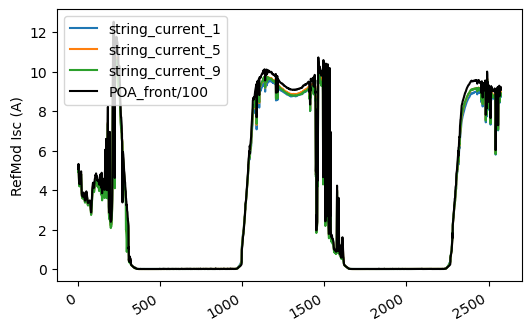

In [17]:
# compare hydra with front POA
get_ipython().run_line_magic('matplotlib', 'inline') #interactive matplotlib

fig=plt.figure(figsize=(6,4))
plt.plot(row2.index,row2.string_current_1,label='string_current_1')
plt.plot(row2.index,row2.string_current_5,label='string_current_5')
plt.plot(row2.index,row2.string_current_9,label='string_current_9')
#plt.plot(row2.index,row2.string_current_11,label='string_current_11')
#plt.plot(row2.index,row2.string_current_12,label='string_current_12')
plt.plot(row2.index,row2.row2Gpoa/100,'k',label='POA_front/100')
plt.legend()
plt.ylabel('RefMod Isc (A)')
fig.autofmt_xdate()

In [18]:
# compare hydra with front POA

row2['refmod_avg'] = pd.DataFrame([row2.string_current_1,row2.string_current_2,row2.string_current_3,
                             row2.string_current_4,row2.string_current_5,row2.string_current_6,
                             row2.string_current_7,row2.string_current_8,row2.string_current_9,
                             row2.string_current_10]).mean()
row2['refmod_min'] = pd.DataFrame([row2.string_current_1,row2.string_current_2,row2.string_current_3,
                             row2.string_current_4,row2.string_current_5,row2.string_current_6,
                             row2.string_current_7,row2.string_current_8,row2.string_current_9,
                             row2.string_current_10]).min()

refmod_fit = np.polyfit(row2.row2Gpoa, row2['refmod_avg'], deg=1)
refmod_fit_min = np.polyfit(row2.row2Gpoa, row2['refmod_min'], deg=1)
print(refmod_fit)
print(f'RefMod = {refmod_fit[0]:0.5f} Gtotal')
print(f'RefMod_min = {refmod_fit_min[0]:0.5f} Gtotal')
#print(row2.refmod_avg.head())

[ 0.0095649  -0.00197101]
RefMod = 0.00956 Gtotal
RefMod_min = 0.00945 Gtotal


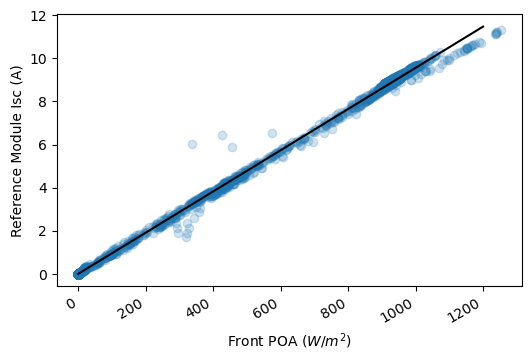

In [24]:
# compare hydra with front POA
get_ipython().run_line_magic('matplotlib', 'inline') #interactive matplotlib




fig=plt.figure(figsize=(6,4))
#plt.plot(row2.row2Gpoa,row2.string_current_1,marker='.',linestyle='',label='string_current_1')
#plt.plot(row2.row2Gpoa,row2.string_current_5,marker='.',linestyle='',label='string_current_5')
plt.plot(row2.row2Gpoa,row2.refmod_avg,marker='.',linestyle='',label='refmod_avg', alpha=0.2, markersize=12)
plt.plot([0,1200],refmod_fit[1]+refmod_fit[0]*np.array([0,1200]),'k',label='fit' )
#plt.legend()
#plt.title(f'Refmod with rear covered = {refmod_fit[0]:0.5f} Gtotal')

plt.xlabel(r'Front POA ($W/m^2$)')
plt.ylabel('Reference Module Isc (A)')
fig.autofmt_xdate()

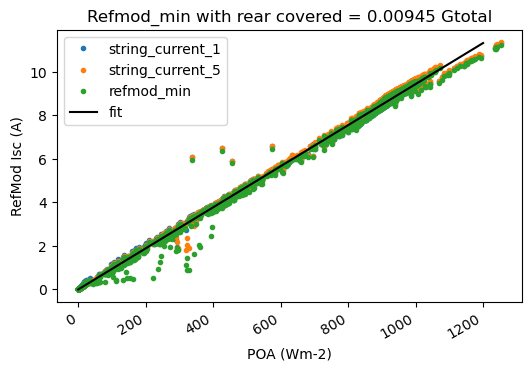

In [12]:
# compare hydra_min with front POA
get_ipython().run_line_magic('matplotlib', 'inline') #interactive matplotlib




fig=plt.figure(figsize=(6,4))
plt.plot(row2.row2Gpoa,row2.string_current_1,marker='.',linestyle='',label='string_current_1')
plt.plot(row2.row2Gpoa,row2.string_current_5,marker='.',linestyle='',label='string_current_5')
plt.plot(row2.row2Gpoa,row2.refmod_min,marker='.',linestyle='',label='refmod_min')
plt.plot([0,1200],refmod_fit_min[1]+refmod_fit_min[0]*np.array([0,1200]),'k',label='fit' )
plt.legend()
plt.title(f'Refmod_min with rear covered = {refmod_fit_min[0]:0.5f} Gtotal')

plt.xlabel('POA (Wm-2)')
plt.ylabel('RefMod Isc (A)')
fig.autofmt_xdate()